In [1]:
import pickle
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
#from google.colab import drive

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from collections import deque

In [4]:
# hyperparameters
gamma = 0.99
tau = 1e-3
epsilon_decay = 0.995
decay_method = "exp"

In [5]:
# environment set-up
lr = 5e-4 #learning rate for Adam optimization
episodes = 700
#episodes = 5
steps = 500
#steps = 20
env = gym.make('LunarLander-v2')
env.reset()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


array([-0.0048584 ,  1.419586  , -0.49212465,  0.38514233,  0.00563651,
        0.11147358,  0.        ,  0.        ], dtype=float32)

In [6]:
# class object for DQN Learning
class ENGINE:
    def __init__(self, env, gamma, lr, tau):
        # init environment
        self.env = env
        
        # Init replay buffer
        self.replay_buffer  = deque(maxlen=int(1e5))
        
        # define discount rate gamma
        # tau for soft-update
        self.gamma = gamma
        self.lr = lr
        self.tau = tau 
        
        # target model is used to generate value estimate and make action selection
        # model is learning from experience and improve estimate
        self.model, self.target_model  = self.NN_model(), self.NN_model()
        
        # Every C step soft update target model Q_hat to model Q
        self.C = 4
        
        # batch size in learning
        self.batch_size = 64
        
        # Counter
        self.t = 0
        
    # create keras NN model
    def NN_model(self):
        input_shape = self.env.observation_space.shape[0]
        output_shape = self.env.action_space.n
        
        # Define Sequential model (linear stack of layers)  
        # Add hidden layers: two hidden layers with the size of 64
        model = Sequential()        
        model.add(Dense(64, input_dim=input_shape, activation="relu"))
        model.add(Dense(64, activation="relu"))
        model.add(Dense(output_shape))
        
        # Define the loss function of mse, Use Adam for optimization
        model.compile(loss="mean_squared_error",optimizer=Adam(lr=self.lr))
        
        return model
    
    # gradient descent learning of Q function
    def learning(self):
        self.t = (self.t + 1) % self.C
        
        # update every C times and make sure buffer is filled with at least size batch size
        if self.t == 0:
            if len(self.replay_buffer) < self.batch_size: 
                return
            
            states, targets_forecast = [], []
            
            # random sample from replay buffer
            samples = random.sample(self.replay_buffer, self.batch_size)
            
            for state, action, reward, new_state, done in samples:
                if done:
                    target = reward
                else:
                    Q_new_state =  np.amax(self.target_model.predict(new_state)[0])
                    target = reward + self.gamma * Q_new_state

                target_forecast = self.model.predict(state)
                target_forecast[0][action] = target
                
                # append to lists for batch processing outside the iteartion
                states.append(state[0])
                targets_forecast.append(target_forecast[0])
            
            # batch learning to train Q function   
            self.model.fit(np.array(states), np.array(targets_forecast), epochs=1, verbose=0)
            
            # soft update weights for models
            current_weights = self.model.get_weights()
            target_weights = self.target_model.get_weights()
            for i in range(len(target_weights)):
                target_weights[i] = self.tau * current_weights[i] + (1 - self.tau) * target_weights[i]
            # assign new weights to target model
            self.target_model.set_weights(target_weights)
    
    # train DQN model
    def train(self, decay_method, epsilon_decay, episodes, steps):

        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = epsilon_decay

        # number of training episodes and max steps for each episode
        self.episodes  = episodes
        self.steps = steps

        # all scores in each trial
        all_scores = []
        # last 100 trial scores
        last_100_scores = deque(maxlen=100)

        # all epsilon values:
        epsilons = []

        for episode in range(self.episodes):
            score = 0
            cur_state = self.env.reset().reshape(1,8)
            epsilons.append(self.epsilon)

            for step in range(self.steps):

                # epsilon-greey to take best action from action-value function
                if np.random.random() < self.epsilon:
                    action = self.env.action_space.sample()
                else:
                    action = np.argmax(self.model.predict(cur_state)[0])

                new_state, reward, done, _ = self.env.step(action)
                score += reward
                new_state = new_state.reshape(1,8)

                # add experience to replay buffer
                self.replay_buffer.append([cur_state, action, reward, new_state, done])

                # learning from current step
                self.learning()
                cur_state = new_state

                if done:
                    break   

            all_scores.append(score)
            last_100_scores.append(score)

            # decay of epsilon, in early training, perform more exploration
            # at later stage of training, perform more exploitation
            if decay_method == "exp":
                self.epsilon *= self.epsilon_decay
            elif decay_method == "lin":
                self.epsilon -= (1-self.epsilon_decay)
            else:
                print("Not applicable decay method")
                return -1
            self.epsilon = max(self.epsilon_min, self.epsilon)

            print('\rtrial {}\t Mean Score: {:.3f} \t with epsilon: {:.3f}'.format(episode, np.mean(last_100_scores), self.epsilon), end="")

            # stop if last 100 consecutive scores
            if np.mean(last_100_scores)>=200.0:
                break                     

        return (all_scores,epsilons)
    
    # test the final DQN model
    def test(self):    

        scores = []

        # run the trained model 100 trials
        for trial in range(100):
            score = 0
            cur_state = self.env.reset().reshape(1,8)
            for step in range(1000):
                action = np.argmax(self.model.predict(cur_state)[0])
                new_state, reward, done, _ = self.env.step(action)
                new_state = new_state.reshape(1,8)
                score += reward
                cur_state = new_state
                if done:
                    break   

            scores.append(score)

        return scores

In [8]:
agent = ENGINE(env,gamma,lr,tau)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
# train and plot with default parameters
train_scores, epsilons = agent.train(decay_method,epsilon_decay,episodes,steps)

In [ ]:
# get test scores for trained model
test_scores = agent.test()

In [10]:
# test and plot
#epsilons = pickle.load(open("epsilons.p","rb"))
#train_scores = pickle.load(open("train_scores.p","rb"))
#test_scores = pickle.load(open("test_scores.p","rb"))

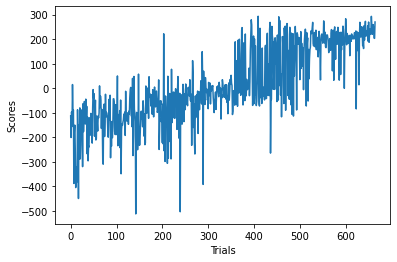

In [11]:
# plot scores for each trial
fig = plt.figure()
plt.plot(np.arange(len(train_scores)), train_scores)
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.show()

In [17]:
# stopped since the average of last 100 trials of the model scores is >200
print('Achieved Mean Score of 200 for last 100 trials with total {:d} trial.\tAverage Score: {:.3f}'.format(len(train_scores), np.mean(train_scores[-100:])))

Achieved Mean Score of 200 for last 100 trials with total 665 trial.	Average Score: 200.537


In [60]:
print('The average test scores from final model is {:.3f}.'.format(np.mean(test_scores)))

The average test scores from final model is 214.800.


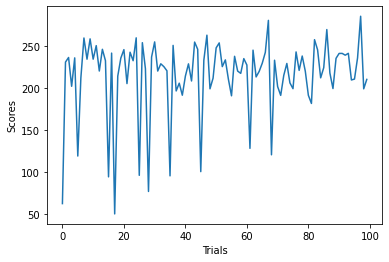

In [14]:
# plot test scores for final model
fig = plt.figure()
plt.plot(np.arange(len(test_scores)), test_scores)
plt.xlabel('Trials')
plt.ylabel('Scores')
plt.show()

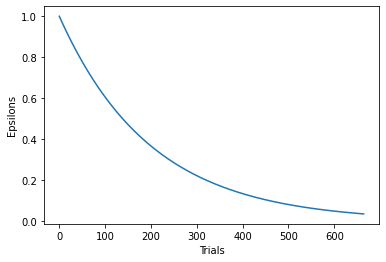

In [18]:
# plot test scores for final model
fig = plt.figure()
plt.plot(np.arange(len(epsilons)), epsilons)
plt.xlabel('Trials')
plt.ylabel('Epsilons')
plt.show()

In [10]:
#drive.mount('/drive')
#pickle.dump(train_scores,open(r'/drive/My Drive/Colab Notebooks/train_scores.p','wb'))
#pickle.dump(train_scores,open(r'/drive/My Drive/Colab Notebooks/epsilons.p','wb'))

Mounted at /drive


In [ ]:
#####################
#### Effect of gamma

In [19]:
gammas = [0.7,0.8,0.9]

In [20]:
scores_gamma = {}
epsilons_gamma = {}

In [ ]:
for _ in gammas:
    agent = ENGINE(env,_,lr,tau)
    scores_gamma[_], epsilons_gamma[_] = agent.train(decay_method,epsilon_decay,episodes,steps)

In [23]:
#for i in range(len(gammas)):
#    scores_gamma[gammas[i]] = pickle.load(open('scores_gamma'+str(i)+'.p',"rb"))
#    epsilons_gamma[gammas[i]] = pickle.load(open('epsilons_gamma'+str(i)+'.p',"rb"))

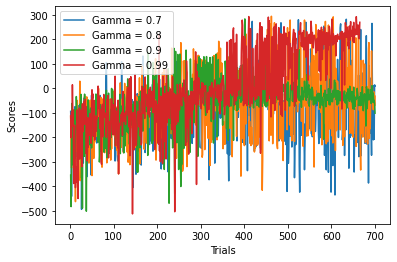

In [34]:
fig = plt.figure()
plt.plot(range(1,701),scores_gamma[gammas[0]], label = 'Gamma = 0.7')
plt.plot(range(1,701),scores_gamma[gammas[1]], label = 'Gamma = 0.8')
plt.plot(range(1,701),scores_gamma[gammas[2]], label = 'Gamma = 0.9')
plt.plot(range(1,len(train_scores)+1),train_scores, label = 'Gamma = 0.99')
plt.legend()
plt.ylabel("Scores")
plt.xlabel("Trials")
plt.show()

In [ ]:
#pickle.dump(scores_gamma,open(r'/drive/My Drive/Colab Notebooks/scores_gamma.p','wb'))
#pickle.dump(epsilons_gamma,open(r'/drive/My Drive/Colab Notebooks/epsilons_gamma.p','wb'))

In [ ]:
#####################
#### Effect of tau

In [36]:
taus = [1e-3, 1e-2, 0.1]

In [ ]:
scores_tau = {}
epsilons_tau = {}

In [35]:
#scores_tau = pickle.load(open('scores_tau.p',"rb"))
#epsilons_tau = pickle.load(open('epsilons_tau.p',"rb"))

In [ ]:
for _ in taus:
    agent = ENGINE(env,gamma,lr,_)
    scores_tau[_], epsilons_tau[_] = agent.train(decay_method,epsilon_decay,episodes,steps)

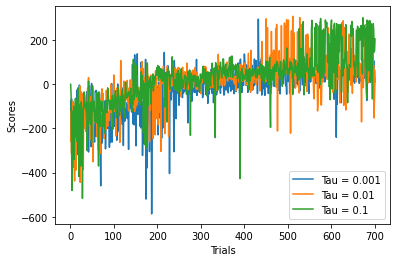

In [65]:
fig = plt.figure()
plt.plot(range(1,701),scores_tau[taus[0]], label = 'Tau = 0.001')
plt.plot(range(1,701),scores_tau[taus[1]], label = 'Tau = 0.01')
plt.plot(range(1,701),scores_tau[taus[2]], label = 'Tau = 0.1')
plt.legend()
plt.ylabel("Scores")
plt.xlabel("Trials")
plt.show()

In [ ]:
#pickle.dump(scores_tau,open(r'/drive/My Drive/Colab Notebooks/scores_tau.p','wb'))
#pickle.dump(epsilons_tau,open(r'/drive/My Drive/Colab Notebooks/epsilons_tau.p','wb'))

In [39]:
#####################
#### Effect of epsilon_decay

In [40]:
epsilon_decays = [0.8, 0.995,1]

In [ ]:
scores_decay = {}
epsilons_decay = {}

In [ ]:
for _ in epsilon_decays:
    agent = ENGINE(env,gamma,lr,tau)
    scores_decay[_], epsilons_decay[_] = agent.train(decay_method,_,episodes,steps)
#pickle.dump(scores_decay,open(r'/drive/My Drive/Colab Notebooks/scores_decay.p','wb'))
#pickle.dump(epsilons_decay,open(r'/drive/My Drive/Colab Notebooks/epsilons_decay.p','wb'))

In [41]:
#scores_decay = pickle.load(open('scores_decay.p',"rb"))
#epsilons_decay = pickle.load(open('epsilons_decay.p',"rb"))

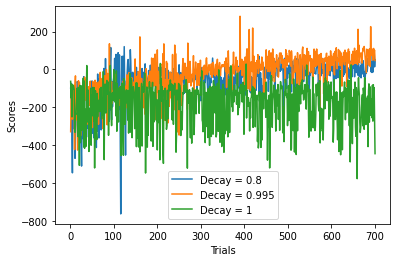

In [42]:
fig = plt.figure()
plt.plot(range(1,701),scores_decay[epsilon_decays[0]], label = 'Decay = 0.8')
plt.plot(range(1,701),scores_decay[epsilon_decays[1]], label = 'Decay = 0.995')
plt.plot(range(1,701),scores_decay[epsilon_decays[2]], label = 'Decay = 1')
plt.legend()
plt.ylabel("Scores")
plt.xlabel("Trials")
plt.show()

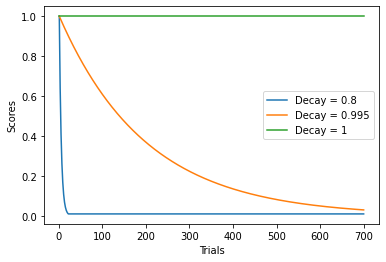

In [43]:
fig = plt.figure()
plt.plot(range(1,701),epsilons_decay[epsilon_decays[0]], label = 'Decay = 0.8')
plt.plot(range(1,701),epsilons_decay[epsilon_decays[1]], label = 'Decay = 0.995')
plt.plot(range(1,701),epsilons_decay[epsilon_decays[2]], label = 'Decay = 1')
plt.legend()
plt.ylabel("Scores")
plt.xlabel("Trials")
plt.show()

In [26]:
#pickle.dump(scores_decay,open(r'/drive/My Drive/Colab Notebooks/scores_decay.p','wb'))
#pickle.dump(epsilons_decay,open(r'/drive/My Drive/Colab Notebooks/epsilons_decay.p','wb'))

In [44]:
epsilon_decays_lin = [0.995,0.997,1]
decay_method_lin = "lin"

In [46]:
scores_decay_lin = {}
epsilons_decay_lin = {}

In [ ]:
for _ in epsilon_decays_lin:
    agent = ENGINE(env,gamma,lr,tau)
    scores_decay_lin[_], epsilons_decay_lin[_] = agent.train(decay_method_lin,_,episodes,steps)
#pickle.dump(scores_decay_lin,open(r'/drive/My Drive/Colab Notebooks/scores_decay_lin.p','wb'))
#pickle.dump(epsilons_decay_lin,open(r'/drive/My Drive/Colab Notebooks/epsilons_decay_lin.p','wb'))

In [47]:
#for i in range(len(epsilon_decays_lin)):
#    scores_decay_lin[epsilon_decays_lin[i]] = pickle.load(open('scores_decay_lin'+str(i)+'.p',"rb"))
#    epsilons_decay_lin[epsilon_decays_lin[i]] = pickle.load(open('epsilons_decay_lin'+str(i)+'.p',"rb"))

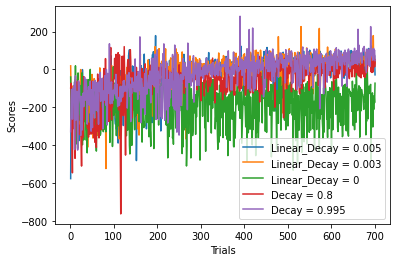

In [57]:
fig = plt.figure()
plt.plot(range(1,701),scores_decay_lin[epsilon_decays_lin[0]], label = 'Linear_Decay = 0.005')
plt.plot(range(1,701),scores_decay_lin[epsilon_decays_lin[1]], label = 'Linear_Decay = 0.003')
plt.plot(range(1,701),scores_decay_lin[epsilon_decays_lin[2]], label = 'Linear_Decay = 0')
plt.plot(range(1,701),scores_decay[epsilon_decays[0]], label = 'Decay = 0.8')
plt.plot(range(1,701),scores_decay[epsilon_decays[1]], label = 'Decay = 0.995')
#plt.plot(range(1,701),scores_decay[epsilon_decays[2]], label = 'Decay = 1')
plt.legend()
plt.ylabel("Scores")
plt.xlabel("Trials")
plt.show()

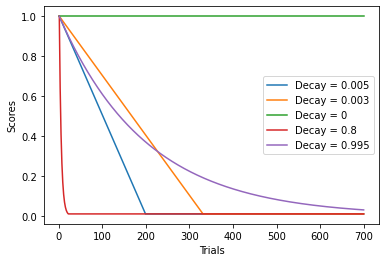

In [58]:
fig = plt.figure()
plt.plot(range(1,701),epsilons_decay_lin[epsilon_decays_lin[0]], label = 'Decay = 0.005')
plt.plot(range(1,701),epsilons_decay_lin[epsilon_decays_lin[1]], label = 'Decay = 0.003')
plt.plot(range(1,701),epsilons_decay_lin[epsilon_decays_lin[2]], label = 'Decay = 0')
plt.plot(range(1,701),epsilons_decay[epsilon_decays[0]], label = 'Decay = 0.8')
plt.plot(range(1,701),epsilons_decay[epsilon_decays[1]], label = 'Decay = 0.995')
#plt.plot(range(1,701),epsilons_decay[epsilon_decays[2]], label = 'Decay = 1')
plt.legend()
plt.ylabel("Scores")
plt.xlabel("Trials")
plt.show()